In this notebook, I will attempt to use RNN models, such as SimpleRNN, LSTM and GRU, to predict the next day's closing price of NASDAQ and NYSE stocks. First, I will try to predict the actual closing price.

Let's start by introducing the functions.

## Function Descriptions

<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">create_dataset</span>
Creates a time-series dataset by windowing the data.

#### Parameters:
- X: Feature data
- y: Target data
- look_back (int): The window size for creating the dataset. Default is 1.

#### Returns:
- X_data: Windowed feature data
- y_data: Windowed target data

</div>

<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">RNN_Regression_Tester</span>
This function builds, compiles, and trains a Recurrent Neural Network (RNN) for regression tasks. It provides options to use either LSTM or GRU cells.
#### Parameters:
- df (DataFrame): DataFrame containing the data
- rnn_type (str): The type of RNN to use ('SimpleRNN', 'LSTM' or 'GRU'). Default is 'LSTM'.
- look_back (int): Window size for the data. Default is 60.
- test_coef (int): Coefficient to determine test set size. Default is 10.
- val_coef (int): Coefficient to determine validation set size. Default is 4.
- dropout (float): Dropout rate for regularization. Default is 0.2.
- epochs (int): Number of training epochs. Default is 50.
- early_stopping (bool): If true, use early stopping during training. Default is True.
- num_layers (int): Number of LSTM layers. Default is 2.
- units (int): Number of neurons in each LSTM layer. Default is 50.
- optimizer (str): Optimizer to use during training. Default is 'rmsprop'.
- activation_function (str): Activation function for LSTM layers. Default is 'tanh'.
- batch_size (int): Size of each training batch. Default is 32.

#### Returns:
- regressor: Trained LSTM model
- X_test: Test data
- scaler_y: Scaler object for the target variable
- y_test[look_back:]: Shifted test target data
- elapsed_time: Time taken to train the model
- history: Training history object
</div>

<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">Keras_RMSE</span>
This function calculates the Root Mean Square Error (RMSE) between the true and predicted values.
#### Parameters:
- y_true: The actual values
- y_pred: The predicted values

#### Returns:
The calculated RMSE value.

</div>

<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">regression_results</span>

Generates a DataFrame containing regression results.

### Parameters:
- epochs (int): Number of training epochs.
- elapsed_time (float): Time taken to train the model.
- train_loss (float): Loss value on the training set.
- train_rmse (float): RMSE on the training set.
- val_loss (float): Loss value on the validation set.
- val_rmse (float): RMSE on the validation set.
- y_test (array-like): True target values for test set.
- predicted_price (array-like): Predicted values for test set.

### Returns:
- df (DataFrame): DataFrame with regression metrics.
    
</div>

<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">plot_loss_regression</span>

Plots the training and validation loss and RMSE values for each epoch.

### Parameters:
- train_loss (list): Training loss values.
- train_rmse (list): Training RMSE values.
- val_loss (list): Validation loss values.
- val_rmse (list): Validation RMSE values.

### Returns:
- Displays a plot.
    
</div>


<div style="background-color: #fafafa; padding: 20px; border: 2px solid #d3d3d3; border-radius: 8px;">

### <span style="color: #696969; font-size: 20px;">plot_predictions</span>

Plots the training and validation loss and accuracy values for each epoch.

### Parameters:
- df (DataFrame): DataFrame containing the original data.
- predicted (list): Predicted values from the model.
- ticker (str): Stock ticker symbol.
- epochs (int): Number of training epochs. Default is False.
- elapsed_time (float): Time taken to train the model. Default is False.
- batch_size (int): Size of each training batch. Default is False.
- activation_function (str): Activation function for LSTM layers. Default is False.
- num_layers (int): Number of LSTM layers. Default is False.
- classification (bool): If true, indicates this is a classification task. Default is False.

### Returns:
- Displays a plot.
    
</div>

In [15]:
import pandas as pd
from IPython.display import display
import numpy as np
from matplotlib import pyplot as plt
import time

from sklearn import preprocessing as pre
from sklearn import metrics as met

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam, RMSprop

import yfinance as yf

def create_dataset(X, y, look_back=1):
    
    """
    Creates a time-series dataset by windowing the data.
    
    Parameters:
    - X: Feature data
    - y: Target data
    - look_back (int): The window size for creating the dataset. Default is 1.
    
    Returns:
    - X_data: Windowed feature data
    - y_data: Windowed target data
    """
    
    X_data, y_data = [], []
    for i in range(len(X) - look_back):
        X_data.append(X[i:(i + look_back)])
        y_data.append(y[i + look_back])
    return np.array(X_data), np.array(y_data)

def Keras_RMSE(y_true, y_pred):
    
    """
    Calculates Root Mean Squared Error (RMSE) for predictions.
    
    Parameters:
    - y_true: True target values
    - y_pred: Predicted values
    
    Returns:
    - RMSE value
    """
    
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def RNN_Regression_Tester(df, target, rnn_type='LSTM', look_back=60, test_coef=10, val_coef=4, dropout=0.2, epochs=50, early_stopping=True, num_layers=2, units=50, optimizer='rmsprop', activation_function='tanh', batch_size=32, reduce_learning = True):
     
    """
    Trains a RNN (LSTM, GRU, SimpleRNN) neural network for regression tasks.
    
    Parameters:
    - df (DataFrame): DataFrame containing the data.
    - target (str): Name of the target column.
    - rnn_type (str): The type of RNN to use ('LSTM', 'GRU', 'SimpleRNN'). Default is 'LSTM'.
    - look_back (int): Window size for the data. Default is 60.
    - test_coef (int): Coefficient to determine test set size. Default is 10.
    - val_coef (int): Coefficient to determine validation set size. Default is 4.
    - dropout (float): Dropout rate for regularization. Default is 0.2.
    - epochs (int): Number of training epochs. Default is 50.
    - early_stopping (bool): If true, use early stopping during training. Default is True.
    - num_layers (int): Number of RNN layers. Default is 2.
    - units (int): Number of neurons in each RNN layer. Default is 50.
    - optimizer (str): Optimizer to use during training. Default is 'rmsprop'.
    - activation_function (str): Activation function for RNN layers. Default is 'tanh'.
    - batch_size (int): Size of each training batch. Default is 32.
    
    Returns:
    - regressor: Trained RNN model
    - X_test: Test data
    - scaler_y: Scaler object for the target variable
    - y_test[look_back:]: Shifted test target data
    - elapsed_time: Time taken to train the model
    - history: Training history object
    
    Notes:
    -----
    regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                                  rnn_type = rnn_type,  
                                                                                                  look_back = look_back,
                                                                                                  test_coef = test_coef,
                                                                                                  val_coef = val_coef,
                                                                                                  dropout = dropout,
                                                                                                  epochs = epoch,
                                                                                                  num_layers=num_layers,
                                                                                                  activation_function=activation_function,
                                                                                                  batch_size = batch_size)
    """
    start_time = time.time()
    
    X = df.values

    if len(df.columns) > 1:
        n_cols = X.shape[1]
    else:
        n_cols = 1

    y = df[target].values

    X_val, X_test = X[-1 * val_coef * look_back * test_coef:-2 * look_back * test_coef], X[-2 * look_back * test_coef:]
    y_val, y_test = y[-1 * val_coef * look_back * test_coef:-2 * look_back * test_coef], y[-2 * look_back * test_coef:]

    X_train, y_train = X[:-2 * look_back * test_coef], y[:-2 * look_back * test_coef]

    scaler_X = pre.MinMaxScaler()
    scaler_y = pre.MinMaxScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_val = scaler_X.transform(X_val)
    X_test = scaler_X.transform(X_test)

    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_val = scaler_y.transform(y_val.reshape(-1, 1))
    y_test_transformed = scaler_y.transform(y_test.reshape(-1, 1))

    X_train, y_train = create_dataset(X_train, y_train, look_back)
    X_val, y_val = create_dataset(X_val, y_val, look_back)
    X_test, y_test_transformed = create_dataset(X_test, y_test_transformed, look_back)

    regressor = Sequential()
    
    if rnn_type == 'LSTM':
        RNNLayer = LSTM
    elif rnn_type == 'GRU':
        RNNLayer = GRU
    elif rnn_type == 'SimpleRNN':
        RNNLayer = SimpleRNN
    else:
        raise ValueError("Invalid RNN Type. Expected 'LSTM', 'GRU' or 'SimpleRNN'")

    regressor.add(RNNLayer(units=units, return_sequences=True, input_shape=(X_train.shape[1], n_cols), activation=activation_function))
    regressor.add(Dropout(dropout))

    for layer in range(num_layers - 1):
        regressor.add(RNNLayer(units=units, return_sequences=True if layer < num_layers - 2 else False, activation=activation_function))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1))

    regressor.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[Keras_RMSE])
    
    callbacks_list = []

    if early_stopping:
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=0, restore_best_weights=True)
        callbacks_list.append(early_stop)
    if reduce_learning:
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=0, min_delta=0.0001)
        callbacks_list.append(reduce_lr)

    history = regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=0)

    end_time = time.time()
    elapsed_time = end_time - start_time

    return regressor, X_test, scaler_y, y_test[look_back:], round(elapsed_time, 2), history

def regression_results(epochs, elapsed_time, train_loss, train_rmse, val_loss, val_rmse, y_test, predicted_price):
    
    """
    Generates a DataFrame containing regression results.
    
    Parameters:
    - epochs (int): Number of training epochs.
    - elapsed_time (float): Time taken to train the model.
    - train_loss (float): Loss value on the training set.
    - train_rmse (float): RMSE on the training set.
    - val_loss (float): Loss value on the validation set.
    - val_rmse (float): RMSE on the validation set.
    - y_test (array-like): True target values for test set.
    - predicted_price (array-like): Predicted values for test set.
    
    Returns:
    - df (DataFrame): DataFrame with regression metrics.
    
    Notes:
    -----
    
    display(regression_results(epochs = epoch,
                               elapsed_time = elapsed_time,
                               train_loss = history.history['loss'],
                               train_rmse = history.history['Keras_RMSE'],
                               val_loss = history.history['val_loss'],
                               val_rmse = history.history['val_Keras_RMSE'],
                               y_test = y_test_NASDAQ_Raw,
                               predicted_price = predicted_price_NASDAQ_LSTM).style.hide())
    """
    
    test_rmse = round(met.mean_squared_error(y_test, predicted_price, squared=False), 2)
    df = pd.DataFrame({"epochs": [epochs], "epochs completed": [len(train_loss)], "elapsed time": [round(elapsed_time,2)], "test RMSE":[round(test_rmse,2)],\
                       "min train loss": [min(train_loss)], "min validation loss": [min(val_loss)],\
                       "min train RMSE": [min(train_rmse)], "min validation RMSE": [min(val_rmse)]})
    return df

def plot_loss_regression(train_loss, train_rmse, val_loss, val_rmse):
    
    """
    Plots the training and validation loss and RMSE values for each epoch.
    
    Parameters:
    - train_loss (list): Training loss values.
    - train_rmse (list): Training RMSE values.
    - val_loss (list): Validation loss values.
    - val_rmse (list): Validation RMSE values.
    
    Returns:
    - Displays a plot.
    
    Notes:
    -----
    
    plot_loss_regression(train_loss = history.history['loss'],
                         train_rmse = history.history['Keras_RMSE'],
                         val_loss = history.history['val_loss'],
                         val_rmse = history.history['val_Keras_RMSE'])
    """
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    axs[0].plot(train_loss, color='b', label='Training Loss')
    axs[0].plot(val_loss, color='r', label='Validation Loss')
    axs[0].set_title("Loss curves")
    axs[0].legend(loc='best', shadow=True)
    axs[1].plot(train_rmse, color='b', label='Training RMSE')
    axs[1].plot(val_rmse, color='r', label='Validation RMSE')
    axs[1].set_title("RMSE curves")
    axs[1].legend(loc='best', shadow=True)
    plt.show()    
    
def plot_predictions(df, predicted, ticker, rnn_type = False, dropout = False, epochs = False, num_layers = False, activation_function = False, batch_size = False, elapsed_time = False, classification = False, line = False):
    
    """
    Visualizes the actual versus predicted prices using bar charts and line graphs.
    
    Parameters:
    - df (DataFrame): DataFrame containing the original data.
    - predicted (list): Predicted values from the model.
    - ticker (str): Stock ticker symbol.
    - epochs (int): Number of training epochs.
    - elapsed_time (float): Time taken to train the model.
    - batch_size (int): Size of each training batch.
    - activation_function (str): Activation function for LSTM layers.
    - num_layers (int): Number of LSTM layers.
    - classification (bool): If true, indicates this is a classification task. Default is False.
    
    Returns:
    - Displays a plot.
    
    Notes:
    -----
    
    plot_predictions(df = df,
                     predicted = predicted_price_NASDAQ_LSTM,
                     ticker = ticker,
                     rnn_type = rnn_type,
                     dropout = dropout,
                     epochs = epoch,
                     num_layers=num_layers,
                     activation_function=activation_function,
                     batch_size = batch_size,
                     elapsed_time = elapsed_time,
                     classification = False,
                     line = False)
    
    """
    
    fig, ax = plt.subplots(figsize=(12, 5))
    bar_df = df[-len(predicted):]
    if line:
        ax.plot(bar_df.index, bar_df["Close"], color='red', label=f'{ticker} Closing Price', linewidth=1, marker = "o")
    else:
        color = ["green" if close_price >= open_price else "red" for close_price, open_price in zip(bar_df["Close"], bar_df["Open"])]
        candlesticks = ax.bar(x=bar_df.index, height=np.abs(bar_df["Open"] - bar_df["Close"]), bottom=np.min((bar_df["Open"], bar_df["Close"]), axis=0), color=color, width=0.6, align='center')
        ax.vlines(x=bar_df.index, ymin=bar_df["Low"], ymax=bar_df["High"], color=color)
    
    if classification:
        actual = (df["Close"].rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])[-len(predicted):]).astype(int).values
        errors = [i for i, (a, c) in enumerate(zip(actual, predicted)) if a != c]
        for err in errors:
            ax.axvline(x=bar_df.index[err], color='blue', linestyle='dotted', label='Misclassification' if 'Misclassification' not in [l.get_label() for l in ax.lines] else "")
    else:
        if line:
            ax.plot(bar_df.index, predicted, color='blue', label=f'Predicted {ticker} Closing Price', linewidth=1, marker = "o")
        else:
            ax.plot(bar_df.index, predicted, color='blue', label=f'Predicted {ticker} Closing Price', linewidth=1)
    ax.legend()
    
    title = []
    if epochs:
        title.append(f'# of Epochs: {epochs}, ')
    if elapsed_time:
        title.append(f'Computation Time: {elapsed_time} Seconds, ')
    if batch_size:
        title.append(f'Batch Size: {batch_size}, ')
    if activation_function:
        title.append(f'Activation Function: {activation_function}, ')
    if num_layers:
        title.append(f'# of Layers: {num_layers}, Dropout: {dropout}, ')
    if rnn_type:
        title.append(f'RNN Type: {rnn_type}, ')

    if len(title) > 0:
        title = ''.join(title)[:-2]
    else:
        title = ticker

    ax.set_title(title , fontsize=10)
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{ticker} Closing Price')
    plt.tight_layout()
    plt.show()

Now, I will download the historical prices of the NASDAQ Composite Index to test the performance of the code.

In [16]:
nasdaq = yf.Ticker("^IXIC")
df_NASDAQ = nasdaq.history(period="max")
df_NASDAQ.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-08-15 00:00:00-04:00,13760.480469,13774.980469,13611.940430,13631.049805,4473320000,0.0,0.0
2023-08-16 00:00:00-04:00,13593.169922,13644.320312,13473.030273,13474.629883,6243760000,0.0,0.0
2023-08-17 00:00:00-04:00,13527.299805,13535.089844,13303.450195,13316.929688,5280180000,0.0,0.0
2023-08-18 00:00:00-04:00,13190.019531,13335.870117,13161.759766,13290.780273,4801910000,0.0,0.0
2023-08-21 00:00:00-04:00,13347.299805,13516.861328,13325.591797,13497.589844,3921191000,0.0,0.0


Starting off, I am using only the closing price for my predictions.

After extensive testing, I've found a setup that appears to be optimal for predicting the NASDAQ Composite Price, and this setup involves using just the closing price. If you come across a better mix of settings or have some insightful suggestions, please give me a shout! I am always open to exchanging ideas and improving the model.

### Regression model to predict NASDAQ Close Price using SimpleRNN

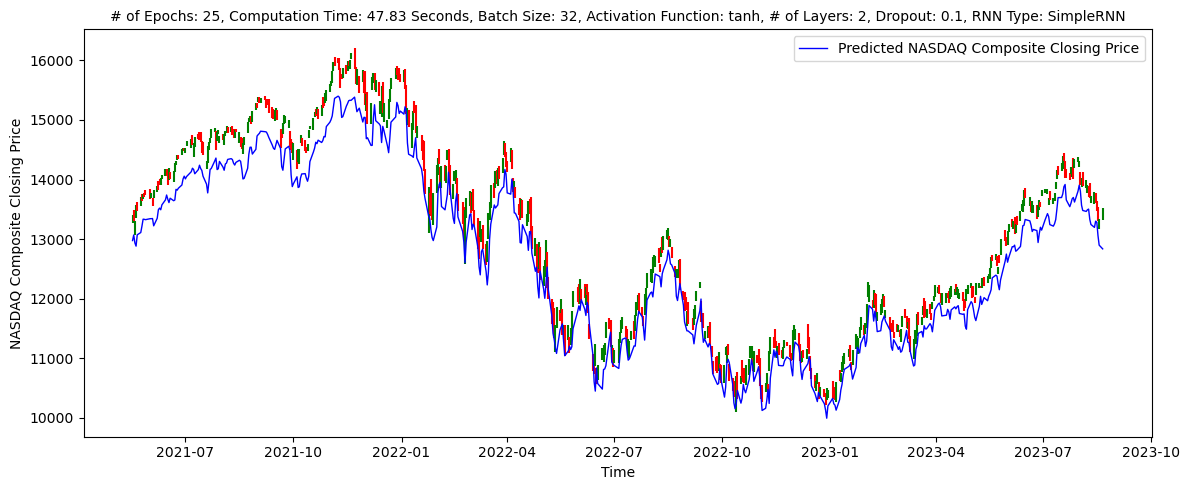

epochs,epochs completed,elapsed time,test RMSE,min train loss,min validation loss,min train RMSE,min validation RMSE
25,14,47.830000,442.990000,0.000130,0.000026,0.010763,0.003835


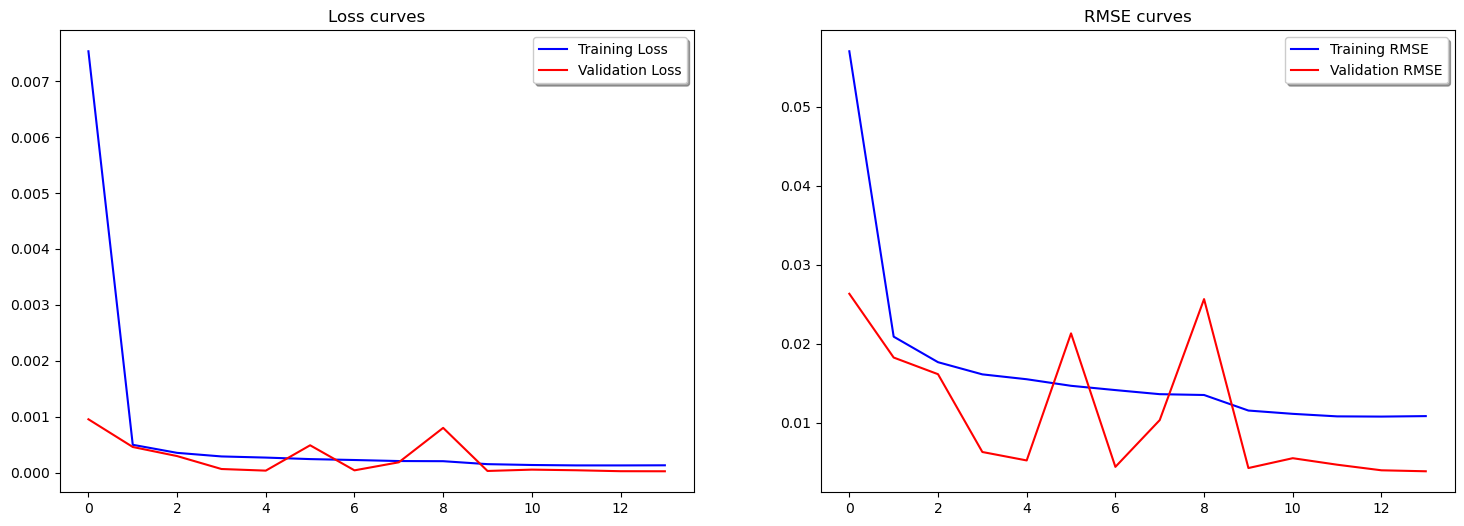

In [17]:
test_df = df_NASDAQ[["Close"]]

rnn_type='SimpleRNN'
num_layers = 2 
activation_function = "tanh"
optimizer = 'rmsprop'
dropout = 0.1
units = 50
epoch = 25
batch_size = 32

look_back = 30
test_coef = 10
val_coef = 16
ticker = "NASDAQ Composite"

regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              val_coef = val_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              batch_size = batch_size)
predicted_price_NASDAQ_SimpleRNN = regressor.predict(X_test, verbose = 0)
predicted_price_NASDAQ_SimpleRNN = scaler_y.inverse_transform(predicted_price_NASDAQ_SimpleRNN).ravel()

plot_predictions(df = df_NASDAQ,
                 predicted = predicted_price_NASDAQ_SimpleRNN,
                 ticker = ticker,
                 rnn_type = rnn_type,
                 dropout = dropout,
                 epochs = epoch,
                 num_layers=num_layers,
                 activation_function=activation_function,
                 batch_size = batch_size,
                 elapsed_time = elapsed_time)

SimpleRNN_NASDAQ = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      val_loss = history.history['val_loss'],
                                      val_rmse = history.history['val_Keras_RMSE'],
                                      y_test = y_test_NASDAQ_Raw,
                                      predicted_price = predicted_price_NASDAQ_SimpleRNN)

display(SimpleRNN_NASDAQ.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'],
                     val_loss = history.history['val_loss'],
                     val_rmse = history.history['val_Keras_RMSE'])

### Regression model to predict NASDAQ Close Price using LSTM

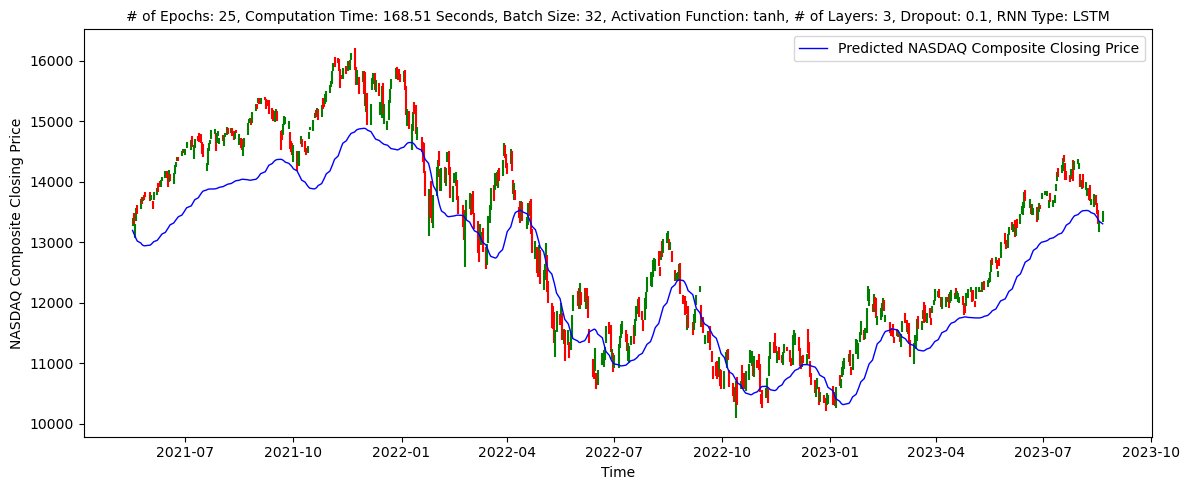

epochs,epochs completed,elapsed time,test RMSE,min train loss,min validation loss,min train RMSE,min validation RMSE
25,13,168.510000,707.450000,0.000159,0.000114,0.011826,0.008113


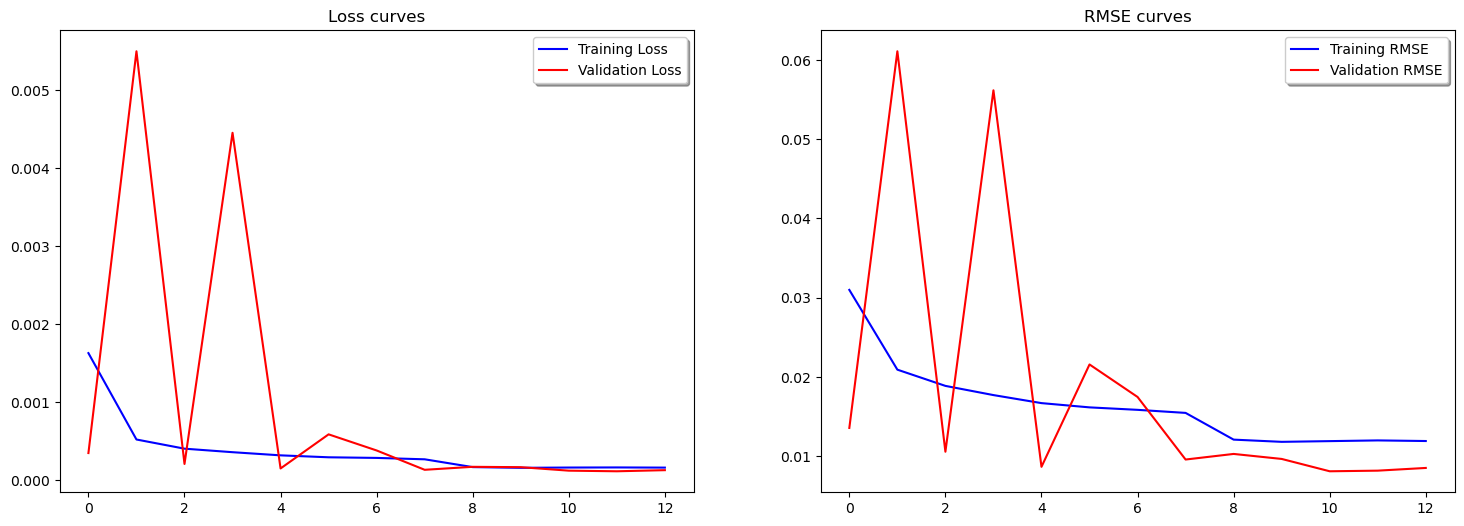

In [18]:
rnn_type='LSTM'
num_layers = 3
optimizer = 'adam'
units = 100
epoch = 25

regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              val_coef = val_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              batch_size = batch_size)
predicted_price_NASDAQ_LSTM = regressor.predict(X_test, verbose = 0)
predicted_price_NASDAQ_LSTM = scaler_y.inverse_transform(predicted_price_NASDAQ_LSTM).ravel()

plot_predictions(df = df_NASDAQ,
                 predicted = predicted_price_NASDAQ_LSTM,
                 ticker = ticker,
                 rnn_type = rnn_type,
                 dropout = dropout,
                 epochs = epoch,
                 num_layers=num_layers,
                 activation_function=activation_function,
                 batch_size = batch_size,
                 elapsed_time = elapsed_time)

LSTM_NASDAQ = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      val_loss = history.history['val_loss'],
                                      val_rmse = history.history['val_Keras_RMSE'],
                                      y_test = y_test_NASDAQ_Raw,
                                      predicted_price = predicted_price_NASDAQ_LSTM)

display(LSTM_NASDAQ.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'],
                     val_loss = history.history['val_loss'],
                     val_rmse = history.history['val_Keras_RMSE'])

### Regression model to predict NASDAQ Close Price using GRU

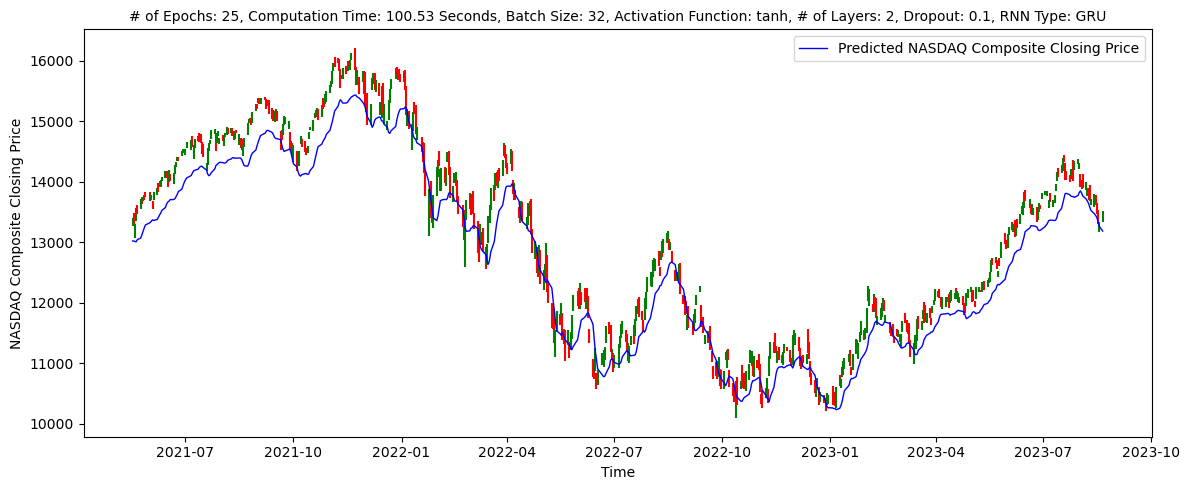

epochs,epochs completed,elapsed time,test RMSE,min train loss,min validation loss,min train RMSE,min validation RMSE
25,11,100.530000,431.710000,0.000138,0.000045,0.010991,0.005104


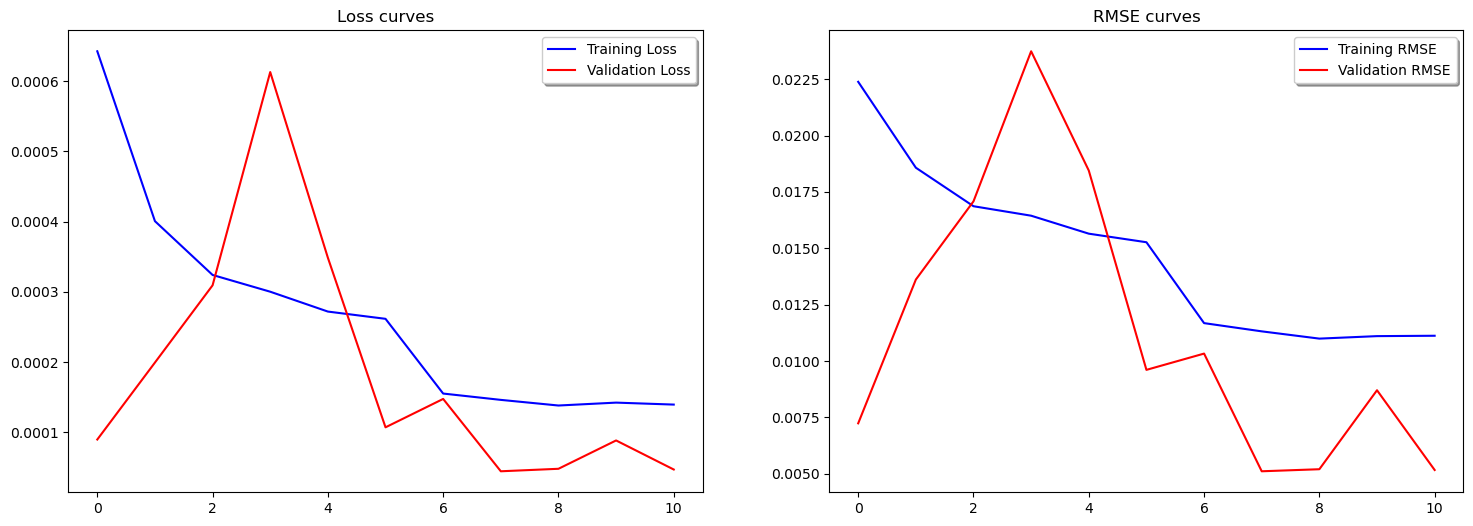

In [19]:
rnn_type='GRU'
num_layers = 2 
activation_function = "tanh"
optimizer = 'sgd'
dropout = 0.1
units = 50
epoch = 25

regressor, X_test, scaler_y, y_test_NASDAQ_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              val_coef = val_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              batch_size = batch_size)
predicted_price_NASDAQ_GRU = regressor.predict(X_test, verbose = 0)
predicted_price_NASDAQ_GRU = scaler_y.inverse_transform(predicted_price_NASDAQ_GRU).ravel()

plot_predictions(df = df_NASDAQ,
                 predicted = predicted_price_NASDAQ_GRU,
                 ticker = ticker,
                 rnn_type = rnn_type,
                 dropout = dropout,
                 epochs = epoch,
                 num_layers=num_layers,
                 activation_function=activation_function,
                 batch_size = batch_size,
                 elapsed_time = elapsed_time)

GRU_NASDAQ = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      val_loss = history.history['val_loss'],
                                      val_rmse = history.history['val_Keras_RMSE'],
                                      y_test = y_test_NASDAQ_Raw,
                                      predicted_price = predicted_price_NASDAQ_GRU)

display(GRU_NASDAQ.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'],
                     val_loss = history.history['val_loss'],
                     val_rmse = history.history['val_Keras_RMSE'])

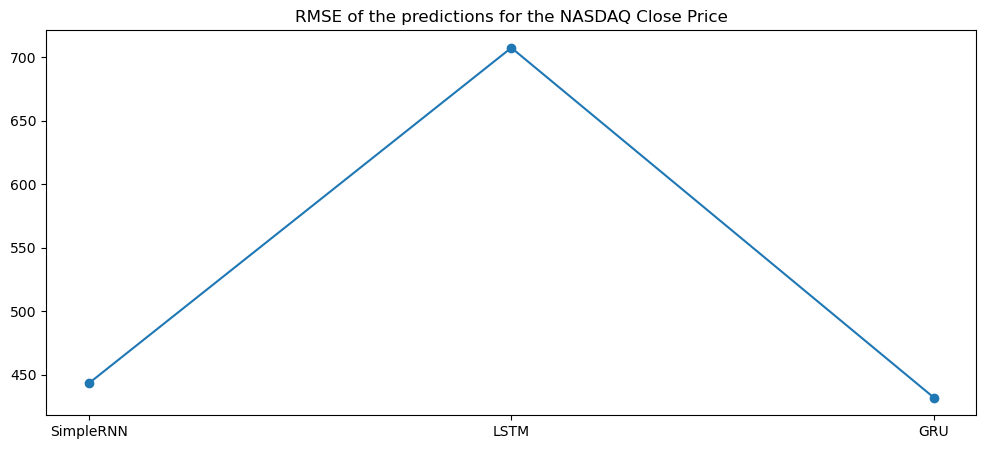

In [20]:
SimpleRNN_NASDAQ_RMSE = SimpleRNN_NASDAQ["test RMSE"].values[0]
LSTM_NASDAQ_RMSE = LSTM_NASDAQ["test RMSE"].values[0]
GRU_NASDAQ_RMSE = GRU_NASDAQ["test RMSE"].values[0]

plt.figure(figsize = (12,5))
plt.plot([SimpleRNN_NASDAQ_RMSE, LSTM_NASDAQ_RMSE, GRU_NASDAQ_RMSE],
        marker = "o")
plt.xticks([0,1,2], ["SimpleRNN", "LSTM", "GRU"])
plt.title("RMSE of the predictions for the NASDAQ Close Price")
plt.show()

Next up, I'm curious to see whether these same settings hold up for the NYSE predictions. Let's dive in and find out!

In [21]:
nyse = yf.Ticker("^NYA")
df_NYSE = nyse.history(period="max")
df_NYSE.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-08-15 00:00:00-04:00,16116.049805,16116.049805,15897.330078,15911.309570,3832250000,0.0,0.0
2023-08-16 00:00:00-04:00,15911.309570,15961.400391,15816.129883,15818.110352,3753910000,0.0,0.0
2023-08-17 00:00:00-04:00,15818.110352,15900.320312,15720.959961,15734.379883,3943700000,0.0,0.0
2023-08-18 00:00:00-04:00,15734.379883,15780.209961,15626.919922,15750.169922,3940400000,0.0,0.0
2023-08-21 00:00:00-04:00,15750.200195,15799.944336,15658.587891,15746.210938,0,0.0,0.0


### Regression model to predict NYSE Close Price using SimpleRNN

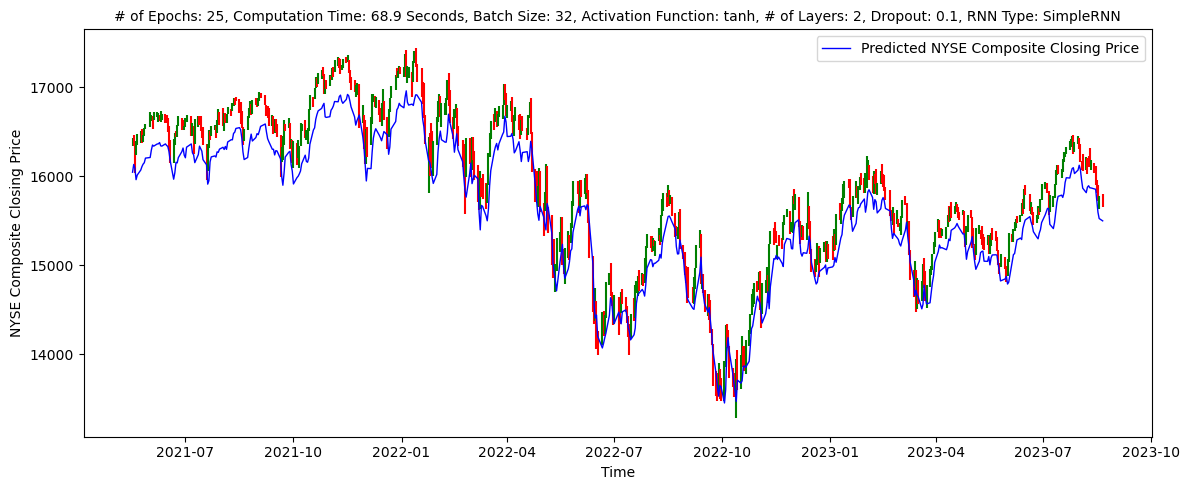

epochs,epochs completed,elapsed time,test RMSE,min train loss,min validation loss,min train RMSE,min validation RMSE
25,17,68.900000,306.400000,0.000264,0.000062,0.015809,0.006760


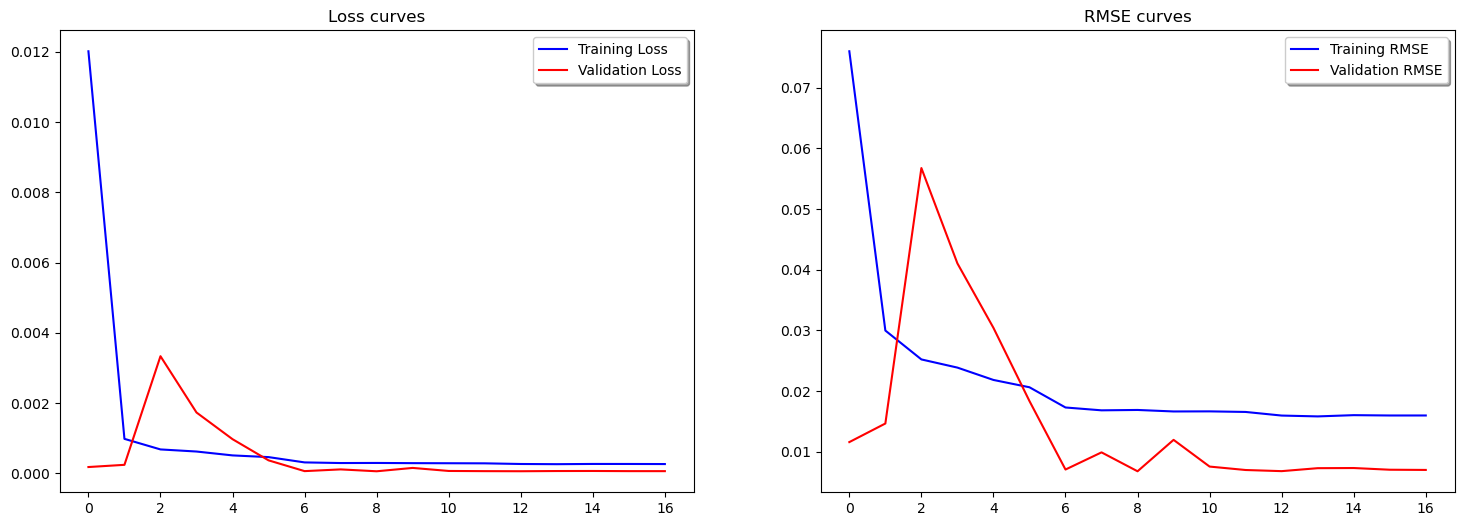

In [22]:
test_df = df_NYSE[["Close"]]

rnn_type='SimpleRNN'
num_layers = 2 
activation_function = "tanh"
optimizer = 'rmsprop'
dropout = 0.1
units = 50
epoch = 25
batch_size = 32

look_back = 30
test_coef = 10
val_coef = 16
ticker = "NYSE Composite"

regressor, X_test, scaler_y, y_test_NYSE_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              val_coef = val_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              batch_size = batch_size)
predicted_price_NYSE_SimpleRNN = regressor.predict(X_test, verbose = 0)
predicted_price_NYSE_SimpleRNN = scaler_y.inverse_transform(predicted_price_NYSE_SimpleRNN).ravel()

plot_predictions(df = df_NYSE,
                 predicted = predicted_price_NYSE_SimpleRNN,
                 ticker = ticker,
                 rnn_type = rnn_type,
                 dropout = dropout,
                 epochs = epoch,
                 num_layers=num_layers,
                 activation_function=activation_function,
                 batch_size = batch_size,
                 elapsed_time = elapsed_time)

SimpleRNN_NYSE = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      val_loss = history.history['val_loss'],
                                      val_rmse = history.history['val_Keras_RMSE'],
                                      y_test = y_test_NYSE_Raw,
                                      predicted_price = predicted_price_NYSE_SimpleRNN)

display(SimpleRNN_NYSE.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'],
                     val_loss = history.history['val_loss'],
                     val_rmse = history.history['val_Keras_RMSE'])

### Regression model to predict NYSE Close Price using LSTM

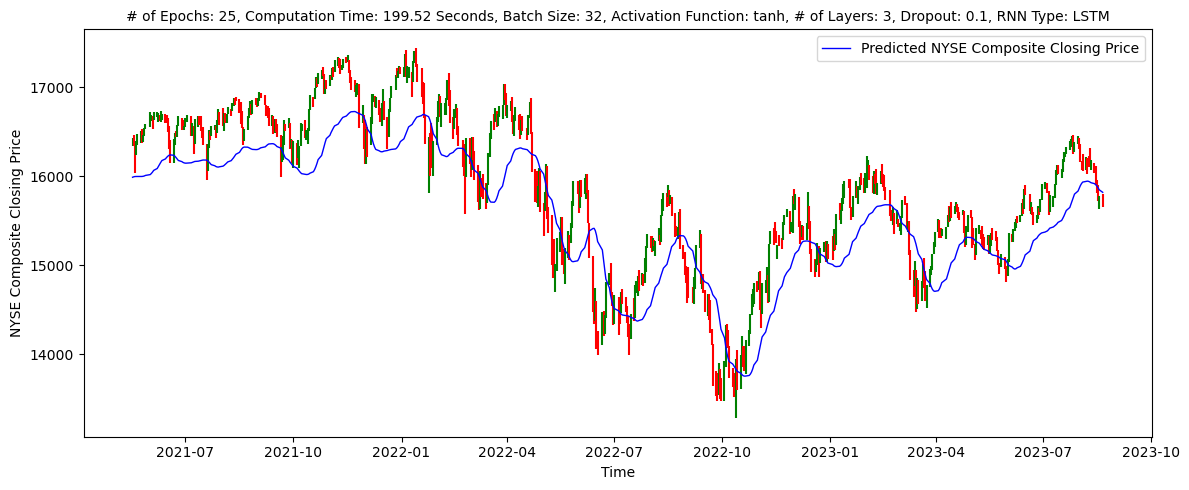

epochs,epochs completed,elapsed time,test RMSE,min train loss,min validation loss,min train RMSE,min validation RMSE
25,14,199.520000,481.720000,0.000316,0.000219,0.017316,0.012118


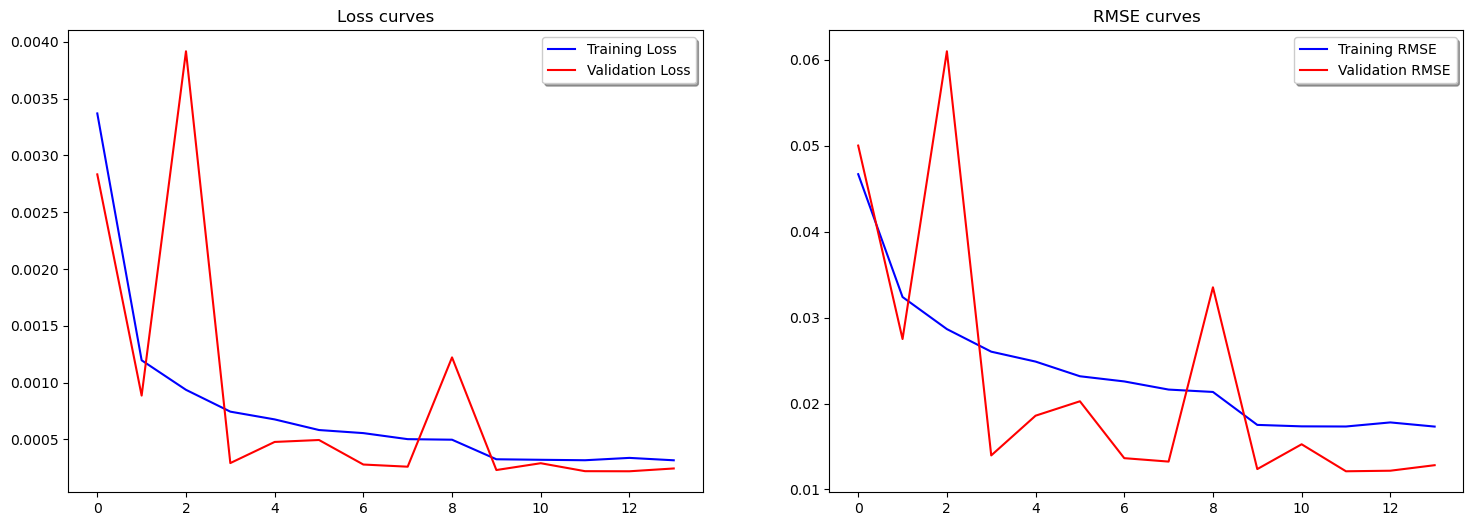

In [23]:
rnn_type='LSTM'
num_layers = 3
optimizer = 'adam'
units = 100
epoch = 25

regressor, X_test, scaler_y, y_test_NYSE_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              val_coef = val_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              batch_size = batch_size)
predicted_price_NYSE_LSTM = regressor.predict(X_test, verbose = 0)
predicted_price_NYSE_LSTM = scaler_y.inverse_transform(predicted_price_NYSE_LSTM).ravel()

plot_predictions(df = df_NYSE,
                 predicted = predicted_price_NYSE_LSTM,
                 ticker = ticker,
                 rnn_type = rnn_type,
                 dropout = dropout,
                 epochs = epoch,
                 num_layers=num_layers,
                 activation_function=activation_function,
                 batch_size = batch_size,
                 elapsed_time = elapsed_time)

LSTM_NYSE = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      val_loss = history.history['val_loss'],
                                      val_rmse = history.history['val_Keras_RMSE'],
                                      y_test = y_test_NYSE_Raw,
                                      predicted_price = predicted_price_NYSE_LSTM)

display(LSTM_NYSE.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'],
                     val_loss = history.history['val_loss'],
                     val_rmse = history.history['val_Keras_RMSE'])

### Regression model to predict NYSE Close Price using GRU

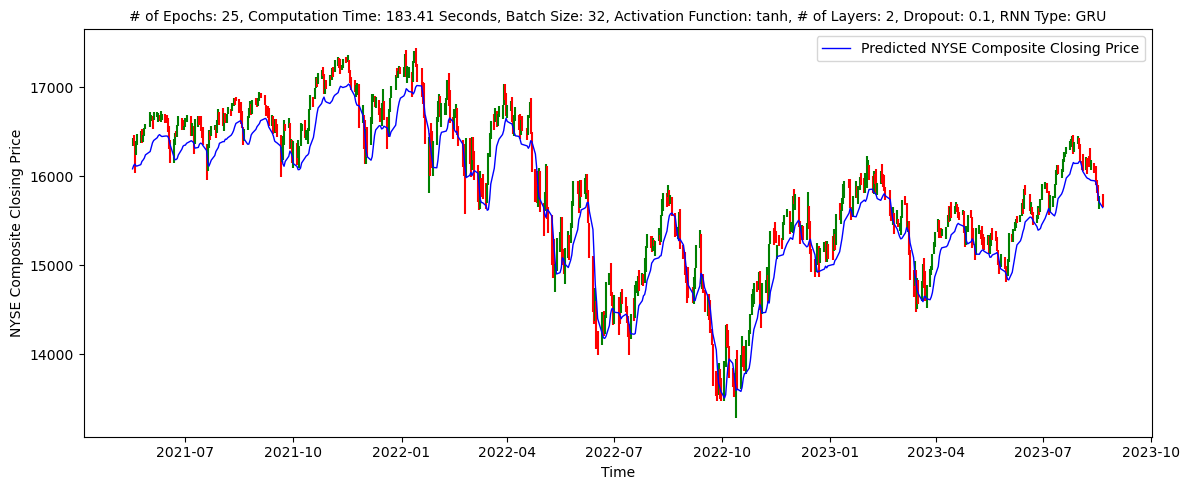

epochs,epochs completed,elapsed time,test RMSE,min train loss,min validation loss,min train RMSE,min validation RMSE
25,18,183.410000,288.920000,0.000279,0.000089,0.016289,0.008003


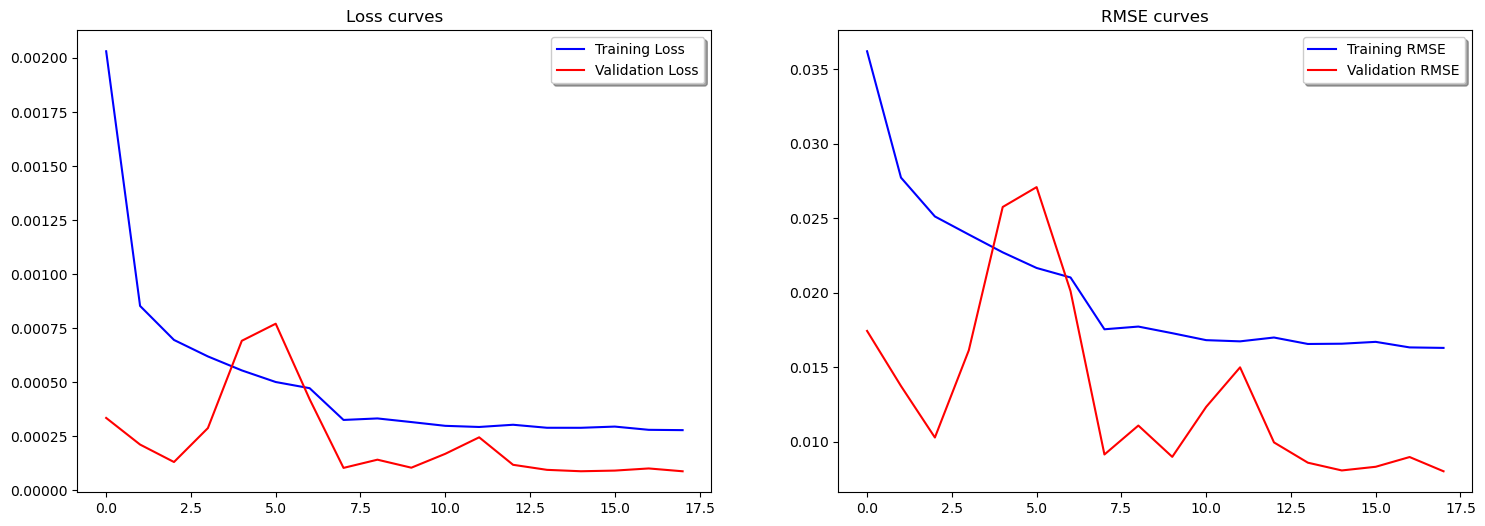

In [24]:
rnn_type='GRU'
num_layers = 2 
activation_function = "tanh"
optimizer = 'sgd'
dropout = 0.1
units = 50
epoch = 25

regressor, X_test, scaler_y, y_test_NYSE_Raw, elapsed_time, history = RNN_Regression_Tester(df = test_df,
                                                                                              target = target,
                                                                                              rnn_type = rnn_type,  
                                                                                              look_back = look_back,
                                                                                              test_coef = test_coef,
                                                                                              val_coef = val_coef,
                                                                                              dropout = dropout,
                                                                                              epochs = epoch,
                                                                                              num_layers=num_layers,
                                                                                              activation_function=activation_function,
                                                                                              batch_size = batch_size)
predicted_price_NYSE_GRU = regressor.predict(X_test, verbose = 0)
predicted_price_NYSE_GRU = scaler_y.inverse_transform(predicted_price_NYSE_GRU).ravel()

plot_predictions(df = df_NYSE,
                 predicted = predicted_price_NYSE_GRU,
                 ticker = ticker,
                 rnn_type = rnn_type,
                 dropout = dropout,
                 epochs = epoch,
                 num_layers=num_layers,
                 activation_function=activation_function,
                 batch_size = batch_size,
                 elapsed_time = elapsed_time)

GRU_NYSE = regression_results(epochs = epoch,
                                      elapsed_time = elapsed_time,
                                      train_loss = history.history['loss'],
                                      train_rmse = history.history['Keras_RMSE'],
                                      val_loss = history.history['val_loss'],
                                      val_rmse = history.history['val_Keras_RMSE'],
                                      y_test = y_test_NYSE_Raw,
                                      predicted_price = predicted_price_NYSE_GRU)

display(GRU_NYSE.style.hide())

plot_loss_regression(train_loss = history.history['loss'],
                     train_rmse = history.history['Keras_RMSE'],
                     val_loss = history.history['val_loss'],
                     val_rmse = history.history['val_Keras_RMSE'])

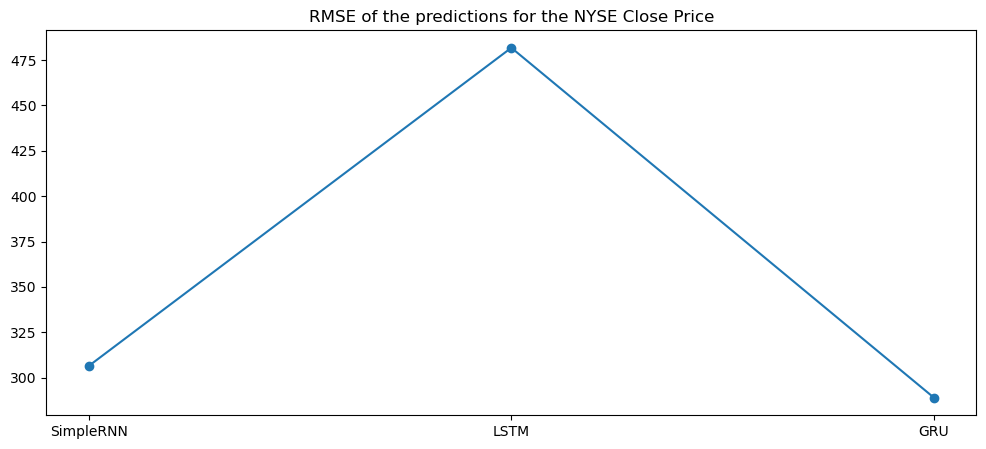

In [25]:
SimpleRNN_NYSE_RMSE = SimpleRNN_NYSE["test RMSE"].values[0]
LSTM_NYSE_RMSE = LSTM_NYSE["test RMSE"].values[0]
GRU_NYSE_RMSE = GRU_NYSE["test RMSE"].values[0]

plt.figure(figsize = (12,5))
plt.plot([SimpleRNN_NYSE_RMSE, LSTM_NYSE_RMSE, GRU_NYSE_RMSE],
        marker = "o")
plt.xticks([0,1,2], ["SimpleRNN", "LSTM", "GRU"])
plt.title("RMSE of the predictions for the NYSE Close Price")
plt.show()

## It seems like we will be rich so fast!!

Results look soo good already!! Let's try out the classification model to detect red and green candles. The functions inputs are same as the prior model.

Now, I will experiment with adding technical indicators to the dataset. Additionally, I am interested in incorporating independent indexes such as the VIX, DJI, etc., into the model to see if the RMSE improves.

But does regression model works well at all? Let's take a closer look.

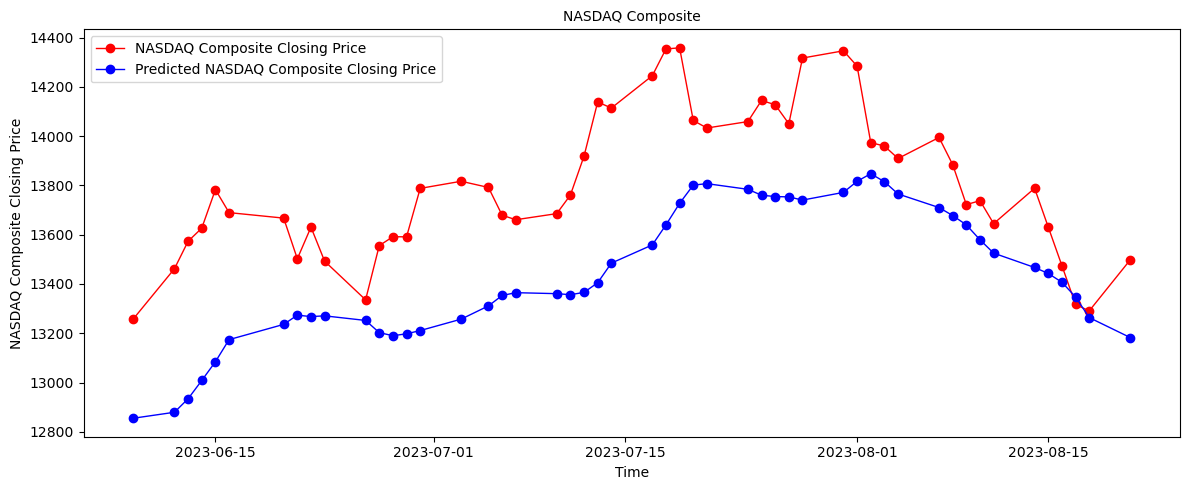

In [28]:
plot_predictions(df = df_NASDAQ,
                 predicted = predicted_price_NASDAQ_GRU[-50:],
                 ticker = "NASDAQ Composite",
                 line=True)

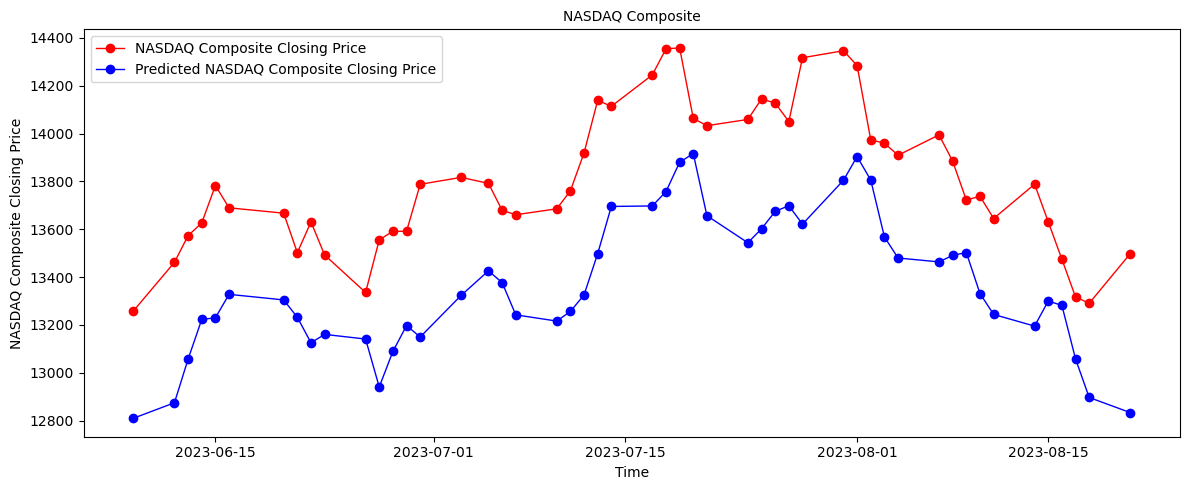

In [29]:
plot_predictions(df = df_NASDAQ,
                 predicted = predicted_price_NASDAQ_SimpleRNN[-50:],
                 ticker = "NASDAQ Composite",
                 line=True)

When looked closely, the predictions seem more like a lagged version of the actual values.

## What have we learned?

- GRU works better for regression than LSTM and SimpleRNN does.

## Next Steps:

- I will experiment with adding technical indicators to the dataset. Additionally, I am interested in incorporating independent indexes such as the VIX, DJI, etc., into the model.
- I will also explore traditional time series models, such as ARIMA, to ascertain their predictive capabilities in comparison to RNN models.
- After thoroughly exploring and optimizing predictions for the indexes, I will shift my focus to predicting individual stock prices.


### I'd genuinely appreciate your thoughts and feedback on this. Please share your insights in the comments below. Your perspective might offer a fresh approach or idea that I haven't considered. Let's collaborate and enrich this discussion together!